##  Deep Neural Networks Project

In this project, you will be working with a real-world data set from the Las Vegas Metropolitan Police Department. The dataset  contains information about the reported incidents, including the time and location of the crime, type of incident, and number of persons involved.

The dataset is downloaded from the public docket at:
https://opendata-lvmpd.hub.arcgis.com

let's read the csv file and transform the data:

In [ ]:
import torch
import pandas as pd
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [ ]:
orig_df = pd.read_csv('LVMPD-Stats.csv', parse_dates=['ReportedOn'])

In [ ]:
df = pd.read_csv('LVMPD-Stats.csv', parse_dates=['ReportedOn'],
                 usecols = ['X', 'Y', 'ReportedOn',
                            'Area_Command','NIBRSOffenseCode',
                            'VictimCount' ] )

df['DayOfWeek'] = df['ReportedOn'].dt.day_name()
df['Time' ]     = df['ReportedOn'].dt.hour
df.drop(columns = 'ReportedOn', inplace=True)

In [ ]:

df['X'] = df['X']
df['Y'] = df['Y']
df['Time'] = pd.factorize(df['Time'])[0]
df['DayOfWeek'] = pd.factorize(df['DayOfWeek'])[0]
df.Area_Command = pd.factorize(df['Area_Command'])[0]
df.VictimCount = pd.factorize(df['VictimCount'])[0]
df.NIBRSOffenseCode = pd.factorize(df['NIBRSOffenseCode'])[0]
df.dropna(inplace=True)

In [ ]:
df= df[['X', 'Y', 'Area_Command', 'NIBRSOffenseCode',
       'DayOfWeek', 'Time','VictimCount']]

In [ ]:
df.values.shape

(275, 7)

# Goal
The goal is to build a predictive model that is trained on the following data:
* latitude and longitude (location)
* Hour of the day
* Day of the week
* Area-of-command code: The police designation of the bureau of the operation.
* Classification code for the crime committed
  
The predicted variable is the number of persons involved in the accident.


## Task 1
* print a few rows of the values in the dataframe ``df`` and explain what each column of data means.
* identify the input and target variables
* what is the range of values in each column? Do you need to scale, shift or normalize your data?



### Explanations
Some Rows are printed below.\
X,Y: are the langitude and longitude respectively, of where the crime took place.
Defined,Longitude ranges from -180 to 180, and Latitude ranges from -90 to 90\
Area_Command: this is the precinct or jurisdiction, a value representing which station handled it\
NIBRSOffenseCode:A category representing the type or severity of the incident. Certain crimes are in each.\
DayOfWeek: An integer value of which day of the week the incident took place\
Time: The hour value from the time of the incident.\
VictimCount:Amount of victims reported in the incident


### Inputs and Target
The **inputs**:  X,	Y,	Area_Command,	NIBRSOffenseCode,	DayOfWeek,	Time,\
The **Target** variable is 'VictimCount'


### Printing Rows

In [ ]:
#Printing 5 rows of the df values
print('X '+'Y '+'Area_Command '+'NIBRSOffenseCode '+'DayOfWeek '+ 'Time '+'VictimCount :',*df.values[20])
df[20:30].style #printing ten rows of data

X Y Area_Command NIBRSOffenseCode DayOfWeek Time VictimCount : -115.11299775 36.1739381400001 2.0 1.0 2.0 2.0 0.0


,X,Y,Area_Command,NIBRSOffenseCode,DayOfWeek,Time,VictimCount
20,-115.112998,36.173938,2,1,2,2,0
21,-115.156989,36.179111,1,1,2,11,1
22,-115.221019,36.196659,8,1,6,1,0
23,-115.070355,36.230058,0,1,0,12,0
24,-115.162821,36.144180,2,1,0,4,0
25,-115.138937,36.171743,2,1,6,8,1
26,-115.150980,36.153165,2,1,3,7,0
27,-115.165538,36.158935,1,1,1,8,1
28,-115.156544,36.197396,1,1,3,0,0
29,-115.198753,36.126212,3,1,3,9,1


### Ranges of values
Most of the data is clear and doesn't need to scale, shift or normalize,
but the X,Y might be helped by shifting, to zero, since the X is usually near -115... and Y near 36... because all of the reported crimes have to be within Las Vegas, so from these values aren't really far from each other.

In [ ]:

'''
# Viewing the Ranges as encountered in the data:
X: latitude ranges from -116 to about -114.6, valid latitudes are defined as -180 to 180
Y: longitude ranges from about 35.07 to 37, valid longitudes are defined as -90 to 90
Area_Command: jurisdiction commanding over incident, from 0-11, so 12 available
NIBRSOffenseCode: Offense category, 0 1 or 2, corresponds to severity
DayOfWeek: Day of week, 0 is Sunday up to 6 is Saturday.
Time: from hour 0 to hour 23, 24hour time
VictimCount:0 to 6 are seen to be reported in this data

'''

valuenames = ['X', 'Y', 'Area_Command', 'NIBRSOffenseCode',
       'DayOfWeek', 'Time','VictimCount']
labels = valuenames
def printRange(valuenames):
  for x in valuenames:
    print("The value ",x, " ranges from ",df[x].min(), " to value ", df[x].max())
printRange(valuenames)


The value  X  ranges from  -116.0  to value  -114.6255705
The value  Y  ranges from  35.0684190000001  to value  37.0000000000001
The value  Area_Command  ranges from  0  to value  11
The value  NIBRSOffenseCode  ranges from  0  to value  2
The value  DayOfWeek  ranges from  0  to value  6
The value  Time  ranges from  0  to value  23
The value  VictimCount  ranges from  0  to value  6


## Task 2

* Create two `DataLoader` objects for training and testing based on the input and output variables. Pick a reasonable batch size and verify the shape of data by iterating over the one dataset and printing the shape of the batched data.

In [ ]:
#Creating two DataLoader objects, one for training and the other for testing
#based on the input and output vars

#The batch size chosen is 64
#The shape of data is verified by iterating and the shape is found to be
#shape of the batched data
batch_size = 64
train_dataset = df
test_dataset = df

train_loader = torch.utils.data.DataLoader(df.values,batch_size=batch_size,shuffle=True)
test_loader = torch.utils.data.DataLoader(df.values,batch_size=batch_size,shuffle=False)


In [ ]:
for batch in train_loader:
  print(batch.size())

torch.Size([64, 7])
torch.Size([64, 7])
torch.Size([64, 7])
torch.Size([64, 7])
torch.Size([19, 7])


## Task 3
In this task you will try to predict number of crime victims as a **real number**. Therefore the machine learning problem is a **regression** problem.

* Define the proper loss function for this task
* what should the size of the predicted output be?
* explain your choice of architecture, including how many layers you will be using
* define an optimizer for training this model, choose a proper learning rate
* write a training loop that obtains a batch out of the  training data and calculates the forward and backward passes over the neural network. Call the optimizer to update the weights of the neural network.
* write a for loop that continues the training over a number of epochs. At the end of each epoch, calculate the ``MSE`` error on the test data and print it.
* is your model training well? Adjust the learning rate, hidden size of the network, and try different activation functions and number of layers to achieve the best accuracy and report it.

In [15]:
#Predicting the number of crime vicims as a REAL NUMBER, regression
#Defining a proper loss function for a Regression problem is MSE
import torch.nn as nn
loss_function  =nn.MSELoss()

#The SIZE of the predicted output tensor should thus be [batch_size,1] since the goal is to predict the victim count value

### Regression Model

In [150]:
# Choice of architecture:
# Amount of layers: 4
# 4 Layers, input, hidden, and output. A simple choice to see effects
# Activation function is sigmoid

class RegressionModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(RegressionModel, self).__init__()

        # Non-linearity
        self.activation = nn.Sigmoid()
        #self.activation = nn.Tanh()

        # Input Layer
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        # Hidden Layers
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, hidden_dim)
        # Output Layer
        self.fc4 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h1  = self.activation(self.fc1(x))
        h2  = self.activation(self.fc2(h1))
        h3  = self.activation(self.fc3(h2))
        out = self.activation(self.fc4(h3))
        return out

In [151]:
#Instantiate the model, hyperparameters
input_dim = 6
hidden_dim = 64
output_dim = 1
learning_rate = 0.0001
model = RegressionModel(input_dim,hidden_dim,output_dim)

#Optimizer chosen SGD
#Optimizer is ccalled to update the weights of the neural network
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [152]:
#Training Loop
# Loop that continues training over epochs
# At end of each epoch MSE is calculated and printed
n_iters = 3000
num_epochs = n_iters / (len(train_dataset) / batch_size)
num_epochs = int(np.ceil(num_epochs))
iter = 0

# Defining the loss function (Mean Squared Error)
criterion = nn.MSELoss()

# Splitting training data
X_train, y_train = df[['X', 'Y', 'Area_Command', 'NIBRSOffenseCode', 'DayOfWeek', 'Time']], df['VictimCount']

# Convert training data to PyTorch tensors
X_train = torch.tensor(X_train.values, dtype=torch.float32)
y_train = torch.tensor(y_train.values, dtype=torch.float32)

# Training parameters
num_epochs = 2000
batch_size = 64

for epoch in range(num_epochs):
    for i in range(0, len(X_train), batch_size):
        # Get a batch of data
        batch_X = X_train[i:i + batch_size]
        batch_y = y_train[i:i + batch_size]

        # Forward pass
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Print the loss for this epoch
    if epoch % 100 == 0:
      print(f'Epoch [{epoch}/{num_epochs}], Loss: {loss.item()}')

#Model is reaches a plateau relatively fast, seems this is not suited for regression.
#Adjusted above learning rate, hidden size, different activation functions and number of layers


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([19])) that is different to the input size (torch.Size([19, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [0/2000], Loss: 0.6409657001495361
Epoch [100/2000], Loss: 0.6400321125984192
Epoch [200/2000], Loss: 0.6393081545829773
Epoch [300/2000], Loss: 0.6387479305267334
Epoch [400/2000], Loss: 0.638315737247467
Epoch [500/2000], Loss: 0.6379839181900024
Epoch [600/2000], Loss: 0.63773113489151
Epoch [700/2000], Loss: 0.637540340423584
Epoch [800/2000], Loss: 0.6373984217643738
Epoch [900/2000], Loss: 0.6372948884963989
Epoch [1000/2000], Loss: 0.6372215747833252
Epoch [1100/2000], Loss: 0.6371721029281616
Epoch [1200/2000], Loss: 0.6371410489082336
Epoch [1300/2000], Loss: 0.6371245384216309
Epoch [1400/2000], Loss: 0.6371191143989563
Epoch [1500/2000], Loss: 0.637122392654419
Epoch [1600/2000], Loss: 0.6371321678161621
Epoch [1700/2000], Loss: 0.6371468305587769
Epoch [1800/2000], Loss: 0.6371651291847229
Epoch [1900/2000], Loss: 0.6371857523918152


## Task 4

In this task, you will try to predict the number of crime victims as a **class number**. Therefore the machine learning problem is a **classification** problem.

* Repeat all the steps in task 3. Specifically, pay attention to the differences with regression.
* How would you find the number of classes on the output data?
* How is the architecture different?
* How is the loss function different?
* Calculate the Accuracy for test data as the number of correct classified outputs divided by the total number of test data in each epoch. Report it at the end of each epoch
* Try a few variations of learning rate, hidden dimensions, layers, etc. What is the best accuracy that you can get?

In [153]:
#Number of classes on output data, number of unique victim counts
num_classes = len(df['VictimCount'].unique())
print("Number of victim count classes:", num_classes)

Number of victim count classes: 7


In [154]:
#Choosing a loss function for classification
#This decreases as predicted converges to actual label
loss = nn.CrossEntropyLoss()

In [191]:
# Define the model
class ClassificationModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_classes):
        super(ClassificationModel, self).__init__()

        #activation
        self.activation = nn.ReLU()

        #Input, hidden, and output section of layers
        self.fc1 = nn.Linear(input_size, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, num_classes)  # Output size matches the number of classes

    def forward(self, x):
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        x = self.fc3(x)
        return x

In [255]:
# Instantiate the model
input_size = 6  # Assuming 6 input features
num_classes = 7 # the amount of different possible victim counts from the data
hidden_dim = 128

model = ClassificationModel(input_size, hidden_dim, num_classes)

#Loss function for classification (Cross-Entropy)
criterion = nn.CrossEntropyLoss()

# Define the optimizer ( trying Stochastic Gradient Descent with a learning rate of 0.01)
# Also tryind Adam, with varyinng Learning Rates
learning_rate = 0.01
#optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


In [256]:
# Separate training data
X_train = df[['X', 'Y', 'Area_Command', 'NIBRSOffenseCode', 'DayOfWeek', 'Time']]
y_train = df['VictimCount']

# Convert training data to PyTorch tensors
X_train = torch.tensor(X_train.values, dtype=torch.float32)
y_train = torch.tensor(y_train.values, dtype=torch.long)
# Uses y_train as integer-encoded, for classification purposes

# Training parameters
num_epochs = 2000
batch_size = 64

for epoch in range(num_epochs):
    for i in range(0, len(X_train), batch_size):
        # Get a batch of data
        batch_X = X_train[i:i + batch_size]
        batch_y = y_train[i:i + batch_size]

        # Forward pass
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Print the loss and accuracy for this epoch
    if epoch % 100 == 0:
      correct=0
      total=0
      accuracy=0

      for data in test_loader:
        labels = batch_y
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        accuracy = 100 * correct / total

      print(f'Epoch [{epoch}/{num_epochs}], Loss: {loss.item()}, Accuracy:{accuracy} ')

Epoch [0/2000], Loss: 11.28621768951416, Accuracy:5.2631578947368425 
Epoch [100/2000], Loss: 0.8612499237060547, Accuracy:68.42105263157895 
Epoch [200/2000], Loss: 0.6757121086120605, Accuracy:63.1578947368421 
Epoch [300/2000], Loss: 0.4873584806919098, Accuracy:89.47368421052632 
Epoch [400/2000], Loss: 0.47502151131629944, Accuracy:78.94736842105263 
Epoch [500/2000], Loss: 0.34833773970603943, Accuracy:94.73684210526316 
Epoch [600/2000], Loss: 0.24855546653270721, Accuracy:100.0 
Epoch [700/2000], Loss: 0.2925220727920532, Accuracy:94.73684210526316 
Epoch [800/2000], Loss: 0.24864749610424042, Accuracy:94.73684210526316 
Epoch [900/2000], Loss: 0.31814804673194885, Accuracy:84.21052631578948 
Epoch [1000/2000], Loss: 0.2147606611251831, Accuracy:94.73684210526316 
Epoch [1100/2000], Loss: 0.21928438544273376, Accuracy:89.47368421052632 
Epoch [1200/2000], Loss: 0.1539366990327835, Accuracy:94.73684210526316 
Epoch [1300/2000], Loss: 0.23784640431404114, Accuracy:89.473684210526

## Task 5

### Reflect on your results

* Write a paragraph about your experience with tasks 3 and 4. How do you compare the results? Which one worked better? Why?
* Write a piece of code that finds an example of a  miss-classification. Calculate the probabilities for the output classes and plot them in a bar chart. Also, indicate what is the correct class label.

### Reflecting
  Tasks 3 and 4 had many similarities, but the classification model works better in this situation. The regression model seems to get stuck on certain values in between.

  For Regression, I ended up with 4 layers. 2 hidden, with hidden dimensions, 64 chosen, and attempted different activation functions but went back to sigmoid. This function seemed to lead to improvement but usually plateaud quickly regardless. Other activations did not seem appropriate for this kind of data and did not improve even with a lot of epochs. Variations in activations and hyperparameters didn't lead to too big of changes.

  For classification, I switched the loss to Cross Entropy, the activation to ReLu, and the optimizer to Adam. The usage of ReLU made a significant difference in performance.And with trial and error, the combination of Adam optimzer with the hidden unit dimension gave the best results.Worked well.



### Miss-classification

In [230]:
#Finding an example of a miss-classification,
#Note: I ran this section after running an earlier version of the model with more errors
misclassified_indices = []
input = X_train
input_label = y_train
for i in range(len(X_train)):
    input_data = input[i:i + 1]  # getting some input,
    true_label = input_label[i]  # True label for the input

    # Forward pass to get the model prediction
    with torch.no_grad():
        outputs = model(input_data)
        _, predicted = torch.max(outputs, 1)

    if predicted.item() != true_label:
        misclassified_indices.append(i)

print("Misclassified Idx:", misclassified_indices[0])

Misclassified Idx: 2


In [238]:
#Misclassified Value, notice model has highest classification prob at '0' but true is '1'
print("Model output class probabilities,", model(X_train[2]))
print("Correct class label:", y_train[2])

Model output class probabilities, tensor([ 3.8886,  3.1250,  1.0299,  0.6364, -0.8512, -2.6978, -4.0968],
       grad_fn=<ViewBackward0>)
Correct class label: tensor(1)


The correct label is : tensor(1)


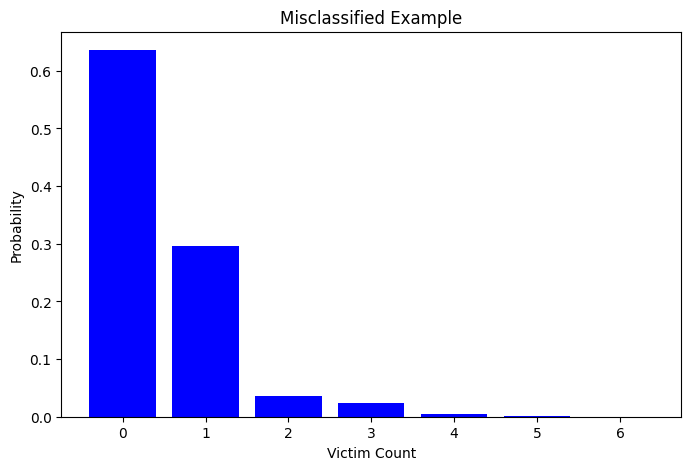

In [257]:
# Using the above output raw tensor values for the 7 classes, convert to probabilities
idx =  misclassified_indices[0]
rawvalues = np.array([3.8886, 3.1250, 1.0299, 0.6364, -0.8512, -2.6978, -4.0968])
correct_label = y_train[2]
print("The correct label is :",correct_label)
# Calculating the probabilities using softmax, the exp proportion out of the sum
# source:https://machinelearningmastery.com/softmax-activation-function-with-python/
#Usually the softmax function is placed on all the outputs of the model.
probs = np.exp(rawvalues) / np.exp(rawvalues).sum()
# Class labels (indices 0 to 6)
class_labels = np.arange(len(rawvalues))

# Plotting the probabilities in a bar chart
plt.figure(figsize=(8, 5))
plt.bar(class_labels, probs, color='blue')
plt.xlabel('Victim Count')
plt.ylabel('Probability')
plt.title('Misclassified Example')
plt.xticks(class_labels)
plt.show()

## Task 6: Exploring the patterns in raw data

* Plot the crime incidents as a `scatter` plot using the corrdinates. Use the color property of each datapoint to indicate the day of the week. Is there a pattern in the plot?
* Now make a new scatter plot and use the color property of each datapoint to indicate the number of persons involved in the incident. Is there a pattern here?
* use numpy (or pandas if you like) to sort the number of crimes reported by the day of the week. What days are most frequent?


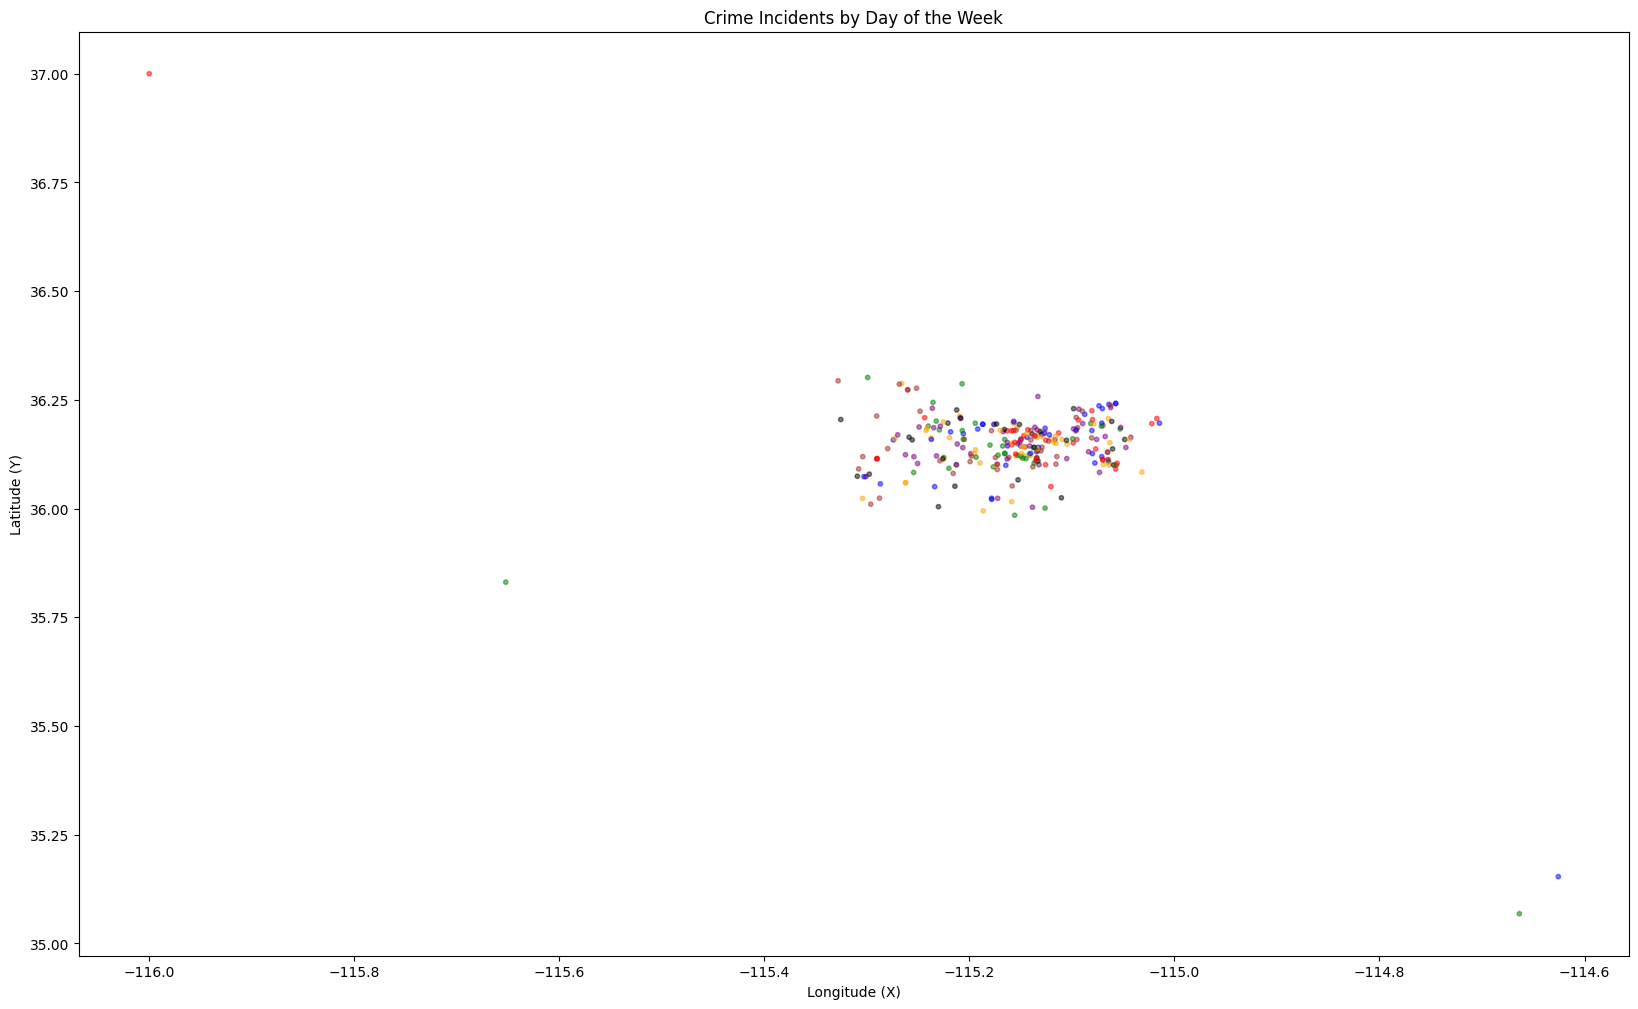

In [ ]:
#Scatter x and y, color is day of week

#There does not seem to be an obvious pattern here, a few days like saturday
#may loook like they  tend to a certain part of the city, but that just may be
# by luck or the coloring.

day_colors = {
    0: 'blue',      # Sunday
    1: 'green',     # Monday
    2: 'red',       # Tuesday
    3: 'purple',    # Wednesday
    4: 'orange',    # Thursday
    5: 'brown',     # Friday
    6: 'black'      # Saturday
}

# Map day numbers to colors
df['DayColor'] = df['DayOfWeek'].map(day_colors)

# Plot the crime incidents as a scatter plot
plt.figure(figsize=(20, 12))
plt.scatter(df['X'], df['Y'], c=df['DayColor'], s=10, alpha=0.5)
plt.xlabel('Longitude (X)')
plt.ylabel('Latitude (Y)')
plt.title('Crime Incidents by Day of the Week')
plt.show()

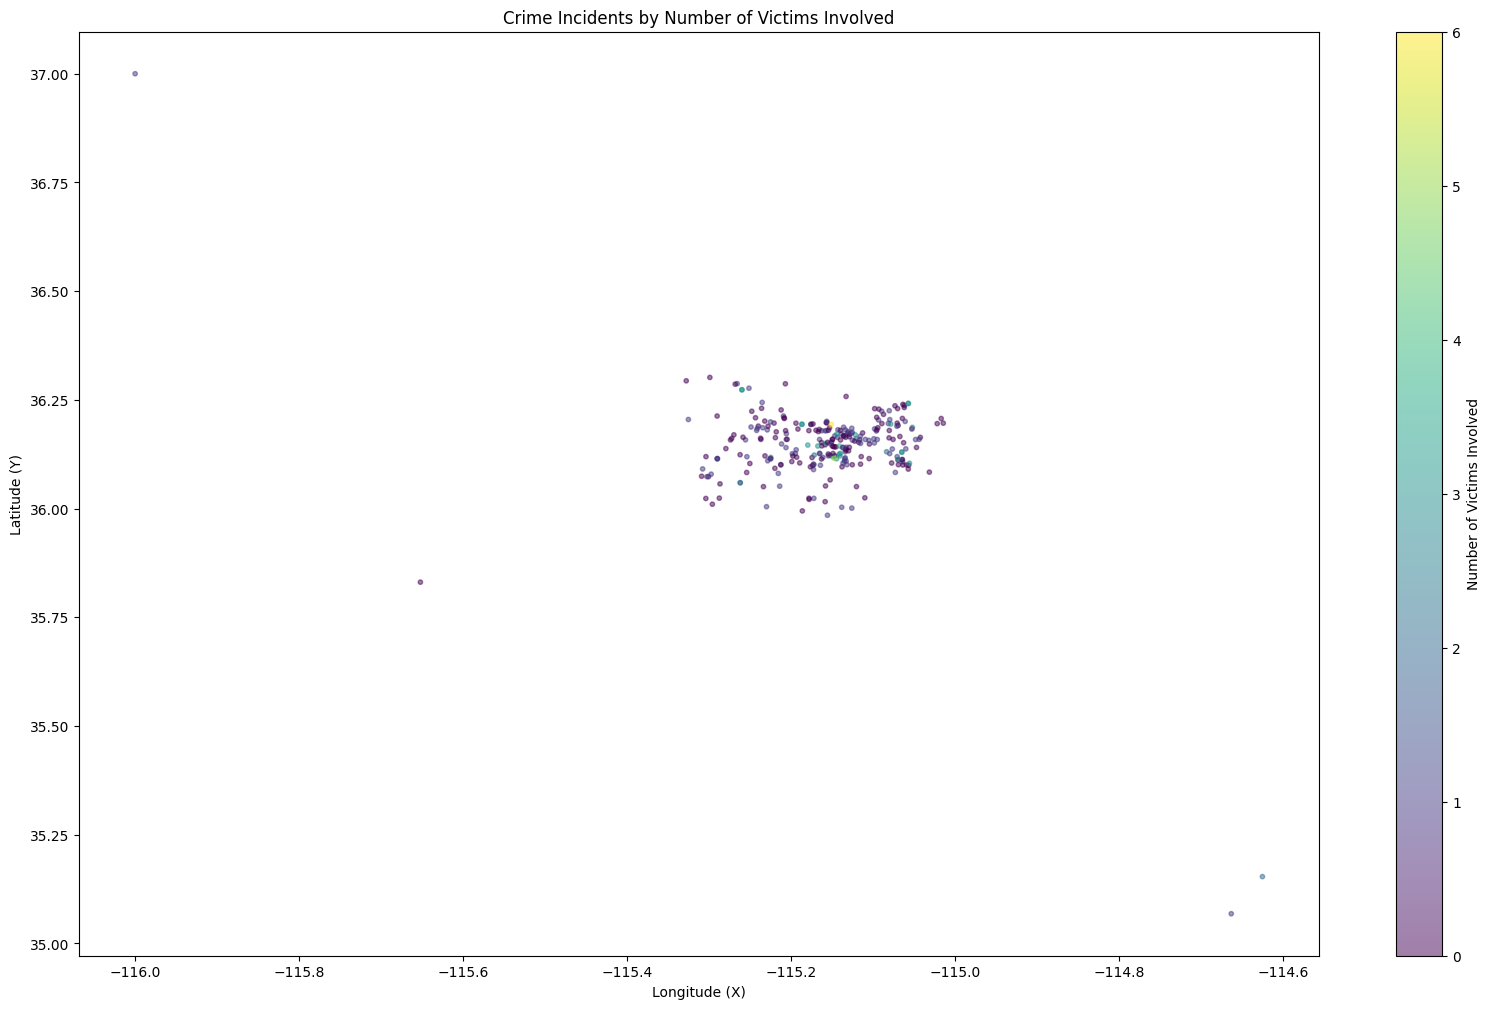

In [ ]:
#Scatter x,y, color is number of persons involved

#The pattern seen here is generally that the vast majority of crimes are low in
# victim count, the majority having 0 or 1 victims.
# The crimes with high counts are extremely rare.

# Plot the crime incidents as a scatter plot
plt.figure(figsize=(20, 12))
plt.scatter(df['X'], df['Y'], c=df['VictimCount'], cmap='viridis', s=10, alpha=0.5)
plt.xlabel('Longitude (X)')
plt.ylabel('Latitude (Y)')
plt.title('Crime Incidents by Number of Victims Involved')
plt.colorbar(label='Number of Victims Involved')
plt.show()

In [ ]:
#Sorting crimes reported by day of week
#The day that is most frequent is found to be Thursday

day_names = {
    0: 'Sunday',    1: 'Monday',   2: 'Tuesday',
    3: 'Wednesday', 4: 'Thursday', 5: 'Friday',
    6: 'Saturday'
}

crime_counts = df.groupby('DayOfWeek').size().reset_index()
crime_counts.columns = ['DayName', 'Count']

# Sort the counts in descending order
sorted_crime_counts = crime_counts.sort_values(by='Count', ascending=False)

# Print the sorted counts
for x in sorted_crime_counts.values:
  print( day_names[x[0]] ,x[1])

Thursday 51
Wednesday 44
Friday 43
Sunday 40
Monday 37
Tuesday 32
Saturday 28
